In [1]:
# import stuff based on the provided assignments

import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from scipy.stats import norm, lognorm
import pandas as pd
from pyfinance.options import BSM
from mpl_toolkits.mplot3d import Axes3D
from datar import f
from datar.dplyr import mutate, filter, if_else, pull, group_by, select

[2021-11-28 11:45:00][datar][WARNING] Builtin name "filter" has been overriden by datar.


In [2]:
# Read given file from data folder in same working directory

xls = pd.ExcelFile('data/isx2010C.xls')
print('All sheets in the file')
sheets = xls.sheet_names
sheets

sheet_order = [0,1,11,10,9,8,7,6,5,4,3,2]


All sheets in the file


In [3]:
# Read data and melt into useable format

df_1 = pd.read_excel(xls, sheets[0])
df_1.rename({df_1.columns[0]:'T','Unnamed: 48': 'S', 'Unnamed: 49': 'r'}, axis='columns', inplace=True)

day = str(sheets[0][3:5])
month = str(sheets[0][5:7])
year = str(sheets[0][7:11])
expiry=year+month+day
print(expiry)

df_1 = df_1.melt(id_vars=['T', 'r', 'S','date'], var_name="E").dropna()
df_1.rename({'value':'Cobs'}, axis='columns', inplace=True)
df_1['date'] = pd.to_datetime(df_1['date'], dayfirst=True)
df_1['name'] = df_1['E'].astype('str') + '-' + expiry
df_start = df_1  >> mutate(r = f.r/100, Mat = f.T, T = f.T/252, S = f.S/1000, E = f.E/1000, Cobs = f.Cobs/1000)
df_start


20100115


,T,r,S,date,E,Cobs,name,Mat
,<float64>,<float64>,<float64>,<datetime64[ns]>,<object>,<float64>,<object>,<int64>
0,0.341270,0.0011,0.49134,2009-09-21,0.34,0.15220,340-20100115,86
1,0.337302,0.0011,0.49435,2009-09-22,0.34,0.15505,340-20100115,85
2,0.333333,0.0011,0.49036,2009-09-23,0.34,0.15240,340-20100115,84
3,0.329365,0.0011,0.48699,2009-09-24,0.34,0.14700,340-20100115,83
...,...,...,...,...,...,...,...,...
4,0.325397,0.0011,0.48411,2009-09-25,0.34,0.14555,340-20100115,82
4036,0.023810,0.0006,0.52861,2010-01-11,0.57,0.00005,570-20100115,6
4037,0.019841,0.0006,0.52429,2010-01-12,0.57,0.00005,570-20100115,5
4038,0.015873,0.0006,0.52793,2010-01-13,0.57,0.00015,570-20100115,4


In [4]:
# calculate IV, BS delta and vega for the options

def iv(row):
    S=row['S']
    E=row['E']
    r=row['r']
    T=row['T']
    Cobs=row['Cobs']
    
    starting_vol = .2
    bsm = BSM(S, E, T, r, starting_vol)
    return bsm.implied_vol(Cobs, precision=1.0e-3)

def delta(row):
    S=row['S']
    E=row['E']
    r=row['r']
    T=row['T']
    Cobs=row['Cobs']
    iv = row['iv']
    
    bsm = BSM(S, E, T, r, iv)
    return bsm.delta()

def vega(row):
    S=row['S']
    E=row['E']
    r=row['r']
    T=row['T']
    Cobs=row['Cobs']
    iv = row['iv']
    
    bsm = BSM(S, E, T, r, iv)
    return bsm.vega()

df_data = df_start.copy()
df_data['iv'] = df_data.apply(iv,axis=1)
df_data = df_data >> filter(0 < f.iv < 0.6)

df_data['delta'] = df_data.apply(delta, axis=1)
df_data['vega'] = df_data.apply(vega, axis=1)

/home/juuso/Documents/school/finaeng1/venv/lib/python3.9/site-packages/pyfinance/options.py:242: RuntimeWarning: divide by zero encountered in double_scalars
  vol = vol + diff / opt.vega()
/home/juuso/Documents/school/finaeng1/venv/lib/python3.9/site-packages/pyfinance/options.py:149: RuntimeWarning: invalid value encountered in double_scalars
  self.d1 = (
/home/juuso/Documents/school/finaeng1/venv/lib/python3.9/site-packages/pyfinance/options.py:151: RuntimeWarning: overflow encountered in double_scalars
  + (self.r + 0.5 * self.sigma ** 2) * self.T


In [7]:
# function that given data, option strike and hedging frequency
# will delta hedge option portfolio by taking
# delta * stock price short position
# returns array of squared errors between option and stock portfolio
# and how many observations there were

def hedge(p_o, p_s, cobs, S, delta):
    option_gain = cobs - p_o
    stock_gain = -delta * (S - p_s['price'])
    error = option_gain + stock_gain
    
    return cobs, {'price':S, 'delta':delta}, error**2
    
def simulate_portfolio(strike, frequency):
    n = 0
    p_o = df_data[df_data['E'] == strike].iloc[0]['Cobs']
    p_s = {
        'price':df_data[df_data['E'] == strike].iloc[0]['S'],
        'delta':df_data[df_data['E'] == strike].iloc[0]['delta']
    }
    error_arr = np.array([])

    for index, data in df_data[df_data['E'] == strike].reset_index(drop=True).iterrows():
        T,r,S,date,E,cobs,name,mat,iv,delta,vega = data

        if n == freq:
            p_o, p_s, error = hedge(p_o, p_s, cobs, S, delta)
            error_arr = np.append(error_arr, error)
            n = 0
        n += 1
    return error_arr, len(df_data[df_data['E'] == strike])

In [9]:
# try hedging with all strikes and frequency from
# min freq to max freq

min_freq = 1
max_freq = 5

obs = {
    'strike':[],
    'freq':[],
    'mse':[],
    'n':[]
}
for strike in df_data['E'].unique():
    for freq in range(min_freq,max_freq):
        error, count = simulate_portfolio(strike, freq)
        obs['strike'].append(strike)
        obs['freq'].append(freq)
        obs['mse'].append(error.mean())
        obs['n'].append(count)
        
hedge_data = pd.DataFrame(obs)
hedge_data

,strike,freq,mse,n
,<float64>,<int64>,<float64>,<int64>
0,0.340,1,5.876369e-07,53
1,0.340,2,6.958838e-07,53
2,0.340,3,3.835669e-07,53
3,0.340,4,5.806040e-07,53
...,...,...,...,...
4,0.345,1,1.881889e-07,8
183,0.565,4,1.222778e-08,40
184,0.570,1,1.014087e-08,64
185,0.570,2,1.795081e-08,64


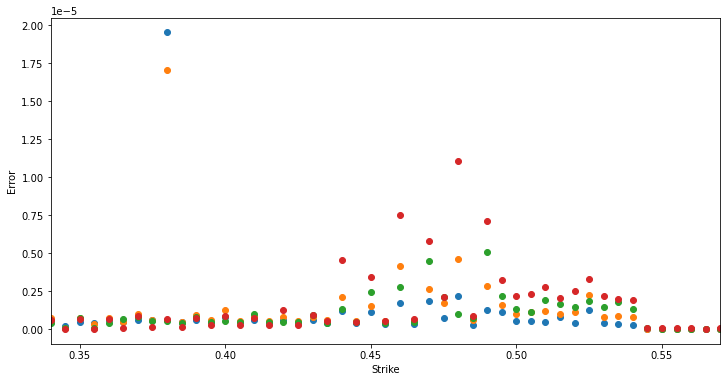

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))

for strike in hedge_data['freq'].unique():
    used = hedge_data[hedge_data['freq'] == strike][['strike','freq', 'mse']].reset_index(drop=True)
    
    #ax.scatter(used['strike'], used['freq'], s=used['mse']*1000000*15)
    ax.scatter(used['strike'], used['mse'])
    #ax.plot(used['strike'], used['mse'], '-o')
    

#plt.ylim(0,1e-5)
plt.xlim(0.34,0.57)
plt.xlabel('Strike')
plt.ylabel('Error')
plt.show()